In [112]:
import sympy as sp
import math
from IPython.display import display

![](images/1.png)

In [84]:
def entropy(P):
    return sum(-p*math.log2(p) for p in P)


![](images/2.png)

In [163]:
class ChannelMatrix:
    def __init__(self,mat,p_x):
        self.mat=sp.Matrix(mat)
        self.p_x=sp.Array(p_x)
        
        M_YX=self.M_YX()
        self.p_y=[sum(M_YX[:,x]) for x in range(3)]
    
    def mean_information_per_symbol(self):
        return DDS(self.p_x).get_entropy()
    
    def M_YX(self):
        M_YX = self.mat.copy()
        for i in range(3):
            for j in range(3):
                M_YX[i,j]*=self.p_x[i]
        return M_YX
    
    def H_YX(self):
        m=self.M_YX()
        s=0
        for i in range(3):
            for j in range(3):
                s-=self.p_x[i]*self.mat[i,j]*math.log2(self.mat[i,j])
        return s
        
    
    def I_XY(self):
        H_YX=self.H_YX()
        H_Y=entropy(self.p_y)
        return (entropy(c.p_y)-(H_Y-H_YX))

In [164]:
P_X = sp.Array([0.2,0.2,0.6])
P_YlX = sp.Matrix([
    [0.15,0.25,0.6], # y1 | x1, y2 | x1 ...
    [0.35,0.25,0.4],
    [0.49,0.5,0.01]
])
t = 0.1 # ms
t_s = 0.1/1000 # s

c=ChannelMatrix(P_YlX,P_X)
M_YX=c.M_YX()
M_YX

Matrix([
[ 0.03, 0.05,  0.12],
[ 0.07, 0.05,  0.08],
[0.294,  0.3, 0.006]])

In [165]:
P_Y=c.p_y
H_X=entropy(P_X)
H_Y=entropy(P_Y)
print("H(X) =",H_X)
print("H(Y) =",H_Y)


H(X) = 1.37095059445467
H(Y) = 1.52773428328664


In [166]:
M_XlY=M_YX.copy()
M_XlY[0,:]/=P_Y[0]
M_XlY[1,:]/=P_Y[1]
M_XlY[2,:]/=P_Y[2]
display(M_XlY)
# H(X|Y) = sum[i,j](-p(x_i|y_j)*log(p(x_i|y_j)))
H_XlY = sum(M_YX[i,j]*math.log2(1/M_XlY[i,j]) for i,j in zip(range(3),range(3))) 
print("H(X|Y) =",H_XlY)

Matrix([
[0.0761421319796954, 0.126903553299492, 0.304568527918782],
[             0.175,             0.125,               0.2],
[  1.42718446601942,  1.45631067961165, 0.029126213592233]])

H(X|Y) = 0.292064064874208


In [167]:
C = 1/t_s*math.log2(len(P_X))

V = H_XlY / t_s
n=200
print("Пропускна здатність: %s bit/s"%C)
print("Швидкість передачі інформації: %s bit/s"%V)
print("Втрати інформації: %s bit/s"%(C-V))
print("Втрати при передачі %s bit: %s"%(n,n*(C-V)/C))
H_XY = sum(-M_YX[i,j]*math.log(M_YX[i,j]) for i,j in zip(range(3),range(3)))
print("Середня кількість прийнятої інформації: %s (bit)"%H_XY)

Пропускна здатність: 15849.62500721156 bit/s
Швидкість передачі інформації: 2920.64064874208 bit/s
Втрати інформації: 12928.9843584695 bit/s
Втрати при передачі 200 bit: 163.145618304368
Середня кількість прийнятої інформації: 0.285679325455823 (bit)


![](images/3.png)

In [169]:
s = "кодуваннядекодування"

d = dict()
for x in s:
    d[x]=d.get(x,0)+1

P_X = [(x,d[x]/len(s)) for x in d]

class Node:
    def __init__(self,name,value):
        self.name=name
        self.value=value
    def __hash__(self):
        return self.name.__hash__()
    def __str__(self):
        return self.name+"\n"+str(self.value)
    def __eq__(self,other):
        if isinstance(other,str):
            return self.name==other
        return self.name==other.name
    def __add__(self,other):
        return Node(self.name+","+other.name,round(self.value+other.value,2))
    def __iter__(self):
        return self.name.__iter__()

print(d)
print(P_X)

{'к': 2, 'о': 2, 'д': 3, 'у': 2, 'в': 2, 'а': 2, 'н': 4, 'я': 2, 'е': 1}
[('к', 0.1), ('о', 0.1), ('д', 0.15), ('у', 0.1), ('в', 0.1), ('а', 0.1), ('н', 0.2), ('я', 0.1), ('е', 0.05)]


In [189]:
import networkx as nx
import matplotlib.pyplot as plt

n=Node("н",0.2)
d=Node("д",0.15)
k=Node("к",0.1)
o=Node("о",0.1)
u=Node("у",0.1)
v=Node("в",0.1)
a=Node("а",0.1)
y=Node("я",0.1)
e=Node("е",0.05)

ye=y+e
print(ye)
aye=a+ye
print(aye)
uv=u+v
print(uv)
ayeuv=aye+uv
print(ayeuv)
ko=k+o
print(ko)
dko=d+k+o
print(dko)
ayeuvdko=ayeuv+dko
print(ayeuvdko)
ayeuvdkon=ayeuvdko+n
print(ayeuvdkon)

G = nx.DiGraph({
    y:[ye],
    e:[ye],
    a:[aye],
    ye:[aye],
    u:[uv],
    v:[uv],
    aye:[ayeuv],
    uv:[ayeuv],
    k:[ko],
    o:[ko],
    d:[dko],
    ko:[dko],
    ayeuv:[ayeuvdko],
    dko:[ayeuvdko],
    n:[ayeuvdkon],
    ayeuvdko:[ayeuvdkon]
})
edge_labels={
    (e,ye):"0",
    (y,ye):"1",
    (a,aye):"0",
    (ye,aye):"1",
    (u,uv):"1",
    (v,uv):"0",
    (aye,ayeuv):"1",
    (uv,ayeuv):"0",
    (k,ko):"1",
    (o,ko):"0",
    (d,dko):"0",
    (ko,dko):"1",
    (ayeuv,ayeuvdko):"1",
    (dko,ayeuvdko):"0",
    (n,ayeuvdkon):"0",
    (ayeuvdko,ayeuvdkon):"1"
}

я,е
0.15
а,я,е
0.25
у,в
0.2
а,я,е,у,в
0.45
к,о
0.2
д,к,о
0.35
а,я,е,у,в,д,к,о
0.8
а,я,е,у,в,д,к,о,н
1.0


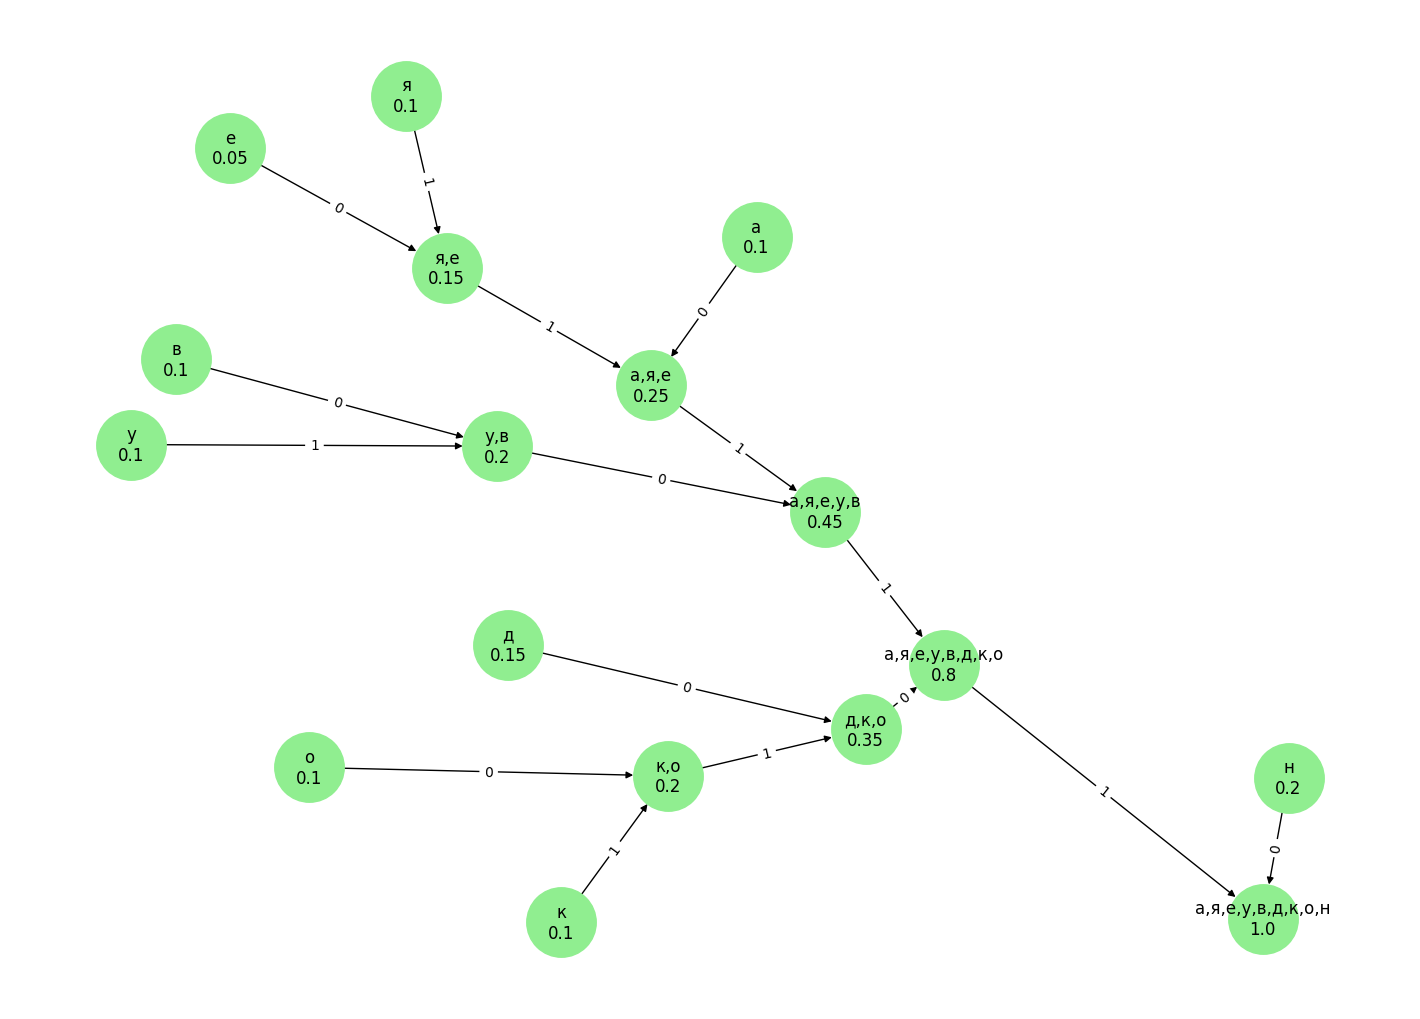

In [192]:
plt.rcParams['figure.figsize'] = 14, 10
pos = nx.spring_layout(G)
nx.draw(G,pos,
        node_color='lightgreen', 
        node_size=2500,
        with_labels=True, 
        arrows=True,
        )
nx.draw_networkx_edge_labels(G,pos, edge_labels=edge_labels)
plt.show()

Huffman encoded:
- н -> 0
- о -> 1010
- к -> 1011
- д -> 100
- в -> 1100
- у -> 1101
- а -> 1110
- я -> 11111
- е -> 11110

![](images/4.png)

In [193]:
def num_to_bits(num, length):
    binary=bin(num)[2:]
    if len(binary)<length:
        binary="0"*(length-len(binary))+binary
    return binary
    
def lz77(bits,include_spaces=False):
    words=set()
    current_word=None
    for x in bits:
        if current_word is None:
            current_word=str(x)
            continue
        if not current_word in words:
            words.add(current_word)
            current_word=str(x)
            continue
        current_word+=str(x)
        
    words_count=len(words)
    bits_count=math.ceil(math.log2(words_count))
    
    words=dict()
    current_word=None
    
    encoded=""
    index=1
    def f(current_word):
        nonlocal encoded,bits_count,include_spaces
        if len(current_word)==1:
            encoded+=num_to_bits(0,bits_count)
            if include_spaces: encoded+=" "
            encoded+=current_word
            if include_spaces: encoded+="  "
        else:
            last_index=words[current_word[:-1]]
            encoded+=num_to_bits(last_index,bits_count)
            if include_spaces: encoded+=" "
            encoded+=current_word[len(current_word)-1]
            if include_spaces: encoded+="  "
    for x in bits:
        if current_word is None:
            current_word=str(x)
            continue
        if not current_word in words:
            f(current_word)
            words[current_word]=index
            index+=1
            current_word=str(x)
            continue
        current_word+=str(x)
    
    f(current_word)
    return encoded
    

In [194]:
nums = [1,0,1,0,0,1,0,0,1,0,1,1,0,0,1,1,0,0]
enc1=lz77(nums,include_spaces=True)
print("test:")
print("encoded bits (with spaces): %s"%enc1)
enc1=lz77(nums,include_spaces=False)
print("encoded bits: %s"%enc1)

test:
encoded bits (with spaces): 000 1  000 0  001 0  010 1  010 0  011 1  011 0  001 1  010 0  
encoded bits: 000100000010010101000111011000110100


![](images/5.png)

In [201]:
nums=[1]*2+[0]*10 + [1]*4 + [0]*9 + [1]*11 + [0]*4

def rle(bits):
    out=list()
    next_lst=[None,None]
    max_num=None
    for b in bits:
        if next_lst[0] is None:
            next_lst[0]=b
            next_lst[1]=1
            max_num=1
            continue
        if next_lst[0]==b:
            next_lst[1]+=1
            continue
        out.append(tuple(next_lst))
        if max_num is None:
            max_sum=next_lst[1]
        else:
            max_num=max(max_num,next_lst[1])
        next_lst=[b,1]
    out.append(tuple(next_lst))
    numeric_bits=math.ceil(math.log2(max_num))
    res = ""
    for x in out:
        binary=bin(x[1])[2:]
        if len(binary)<numeric_bits:
            binary="0"*(numeric_bits-len(binary))+binary
        res+=str(x[0])
        res+=" "
        res+=binary
        res+="  "
    
    return out,res


print("bits =","".join(map(str,nums)))
out,encoded=rle(nums)
print("RLE(nums) with spaces =",encoded)
print("Compression ratio:",len(nums)/len(encoded))

bits = 1100000000001111000000000111111111110000
RLE(nums) with spaces = 1 0010  0 1010  1 0100  0 1001  1 1011  0 0100  
Compression ratio: 0.8333333333333334


![](images/6.png)

In [199]:
X = [10,20,30,40]
s=sum(X)
X_I = [x/s for x in X]
I = [-math.log2(p) for p in X_I]

j=0
for i in I:
    j+=1
    print("I_%d = %s (bit)"%(j,i))

I_1 = 3.321928094887362 (bit)
I_2 = 2.321928094887362 (bit)
I_3 = 1.736965594166206 (bit)
I_4 = 1.3219280948873622 (bit)
